In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# enable interactive plots
%matplotlib widget

# formatting
import fig_specs as fsp
plt.rcParams['figure.figsize'] = (10, 10)  # set default figure size
plt.rcParams['font.family'] = 'sans-serif'          # set default font size
plt.rcParams['font.sans-serif'] = 'Helvetica'          # set default font size
plt.rcParams['font.size'] = 9          # set default font size
plt.rcParams['savefig.bbox'] = 'tight'

# Import and concatenate all 4D results data into suitable dataframes

In [2]:
import os
import pickle

# Set the directory containing the CSV files
csv_dir = './results/4d/results'

# Get a list of all CSV files in the directory
csv_files = [f for f in os.listdir(csv_dir) if f.endswith('.csv')]

# Concatenate all CSV files into a single dataframe
df_sim = pd.concat([pd.read_csv(os.path.join(csv_dir, f)) for f in csv_files])

# Load pickled train time dataframe
with open('./benchmark-policies/4d/wind_0,9_train_time.pkl', 'rb') as f:
    df_train = pickle.load(f)





# Modify df_train
# Create new columns
df_train['grid_size'] = df_train.index.str.extract(r'^(\d{1,2})\d{1}', expand=False).astype(int)
df_train['obstacle_density'] = df_train.index.str.extract(r'^\d{1,2}(\d{1})', expand=False).astype(int)

# define a dictionary to map the old "density" values to new percentage values
mapping = {1: 0, 2: 0.05, 3: 0.10, 4: 0.15}

# replace the old values with the new values
df_train['obstacle_density'] = df_train['obstacle_density'].replace(mapping)



# Modify df_sim
# Create new columns
df_sim['grid_size'] = df_sim['MDP_ID'].astype(str).str.extract(r'^(\d{1,2})\d{1}', expand=False).astype(int)
df_sim['obstacle_density'] = df_sim['MDP_ID'].astype(str).str.extract(r'^\d{1,2}(\d{1})', expand=False).astype(int)

# define a dictionary to map the old "density" values to new percentage values
mapping = {1: 0, 2: 0.05, 3: 0.10, 4: 0.15}

# replace the old values with the new values
df_sim['obstacle_density'] = df_sim['obstacle_density'].replace(mapping)

In [3]:
df_sim.head()

,dimension,MDP_ID,wind_param,sol_method,l1_norm,no_solutions,solver_time,grid_size,obstacle_density
0,4,131,0.8,IP,0.0,5.0,0.610973,13,0.0
1,4,131,0.8,IP,10.0,13.0,1.634126,13,0.0
2,4,131,0.8,IP,4.0,7.0,0.911011,13,0.0
3,4,131,0.8,IP,2.0,7.0,0.919262,13,0.0
4,4,131,0.8,IP,2.0,7.0,0.931227,13,0.0


In [4]:
df_train.head()

,DP4,MC4,grid_size,obstacle_density
"41_wind_0,9",1.767049,0.336776,4,0.00
"42_wind_0,9",1.755515,0.339481,4,0.05
"43_wind_0,9",1.678167,0.310009,4,0.10
"44_wind_0,9",1.589444,0.298224,4,0.15
"51_wind_0,9",4.588190,0.717241,5,0.00


# Plot stuff

## RL

### Training time trends

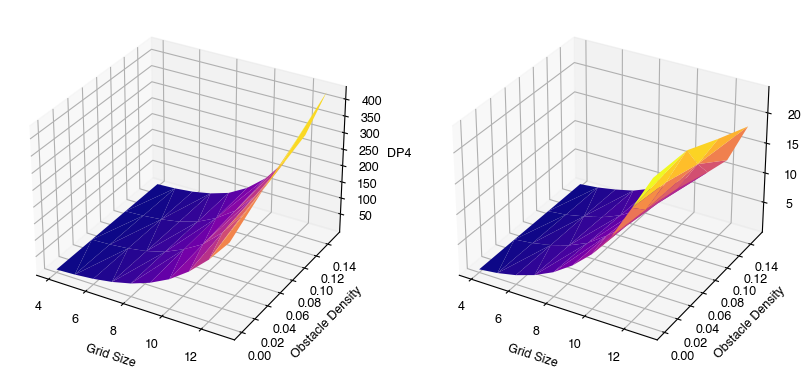

In [5]:
fig = plt.figure()

# First subplot
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_trisurf(df_train['grid_size'], df_train['obstacle_density'], df_train['DP4'], cmap='plasma')
ax1.set_xlabel('Grid Size')
ax1.set_ylabel('Obstacle Density')
ax1.set_zlabel('DP4')


# Second subplot
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_trisurf(df_train['grid_size'], df_train['obstacle_density'], df_train['MC4'], cmap='plasma')
ax2.set_xlabel('Grid Size')
ax2.set_ylabel('Obstacle Density')
ax2.set_zlabel('MC4 Train Time (seconds)')


plt.show()

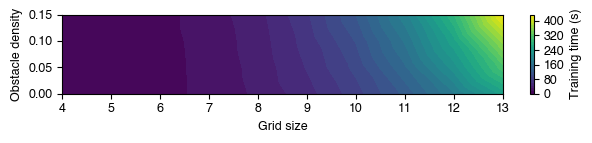

In [73]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.ticker import MaxNLocator

fig = plt.figure(figsize=(fsp.text_width, 1.5))

method = 'dp'

ax = fig.add_subplot()
# Get the x, y, z values
x, y, z_train_mc = df_train['grid_size'], df_train['obstacle_density'], df_train['MC4']
z_train_dp = df_train['DP4']

# Create a triangulation of the irregular grid
triang = tri.Triangulation(x, y)

# Plot the contour
if method == 'mc':
    #levels = np.linspace(0, 1, 17)
    cs = ax.tricontourf(triang, z_train_mc, levels = 40, cmap='plasma')
    cbar = plt.colorbar(cs, ax=ax)
    cbar.locator = MaxNLocator(7)
elif method == 'dp':
    #levels = np.linspace(0, 0.5, 11)
    cs = ax.tricontourf(triang, z_train_dp, levels = 40, cmap='viridis')
    cbar = plt.colorbar(cs, ax=ax)
    cbar.locator = MaxNLocator(6)

# Add a colorbar to show the scale of the values in the contours
#cbar = plt.colorbar(cs, ax=ax)

# Set labels for the axes
ax.set_xlabel('Grid size')
ax.set_ylabel('Obstacle density')
cbar.ax.set_ylabel('Training time (s)')
ax.set_yticks(np.arange(0, 0.16, 0.05))
plt.grid(False)

save = False
plt.tight_layout()
if save:
    plt.savefig(f'{fsp.fig_path}/4d-{method}-train-times-wind-0.9.pdf')
plt.show()

It's clear that, although the training time trend with respect to grid size is similar, that with respect to obstacle density is not.
Although more obstacles implies more time in computing stuff (whether that's state space backups in DP or experienced simulations in MC), another factor affects the time in MC — the length of simulations. More obstacles --> more crashes --> shorter simulations --> less time to simulate.

### RL Performance trends

In [6]:
df_sim[df_sim['sol_method'].isin(['DP', 'MC'])].head()

,dimension,MDP_ID,wind_param,sol_method,l1_norm,no_solutions,solver_time,grid_size,obstacle_density
300,4,131,0.8,MC,3.0,NaN,NaN,13,0.0
301,4,131,0.8,MC,0.0,NaN,NaN,13,0.0
302,4,131,0.8,MC,3.0,NaN,NaN,13,0.0
303,4,131,0.8,MC,2.0,NaN,NaN,13,0.0
304,4,131,0.8,MC,3.0,NaN,NaN,13,0.0


/var/folders/7q/vfb4br_x0vnc613rxty89lnh0000gn/T/ipykernel_1725/2328342393.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_mc = df_sim_mc.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean() # take mean values per benchmark MDP
/var/folders/7q/vfb4br_x0vnc613rxty89lnh0000gn/T/ipykernel_1725/2328342393.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_dp = df_sim_dp.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean()
/var/folders/7q/vfb4br_x0vnc613rxty89lnh0000gn/T/ipykernel_1725/2328342393.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean 

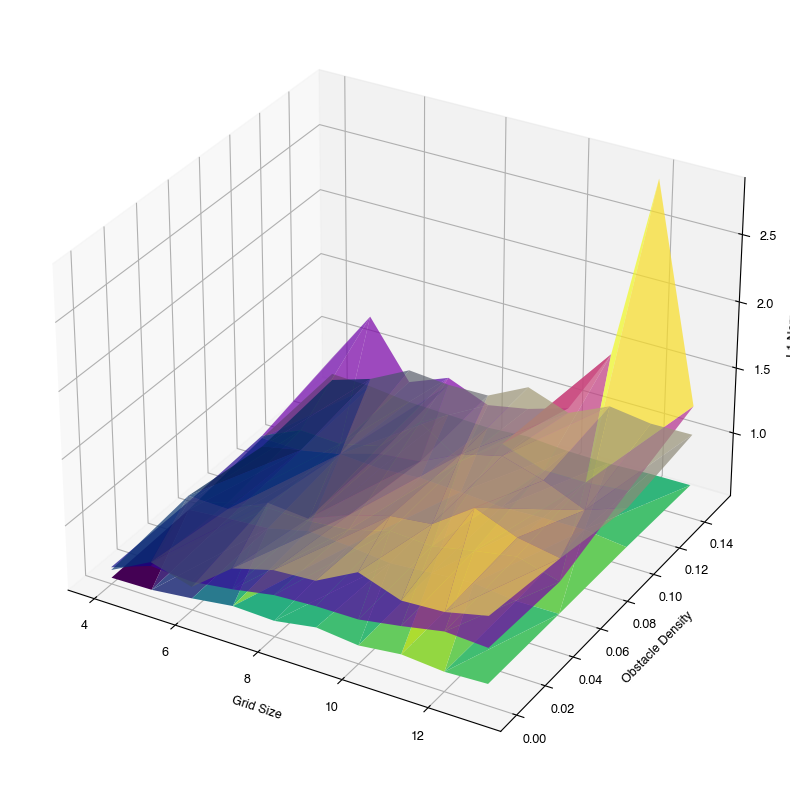

In [75]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

df_sim_mc = df_sim[df_sim['sol_method'] == 'MC']
data_mc = df_sim_mc.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean() # take mean values per benchmark MDP
df_sim_dp = df_sim[df_sim['sol_method'] == 'DP']
data_dp = df_sim_dp.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean()
df_sim_ip = df_sim[df_sim['sol_method'] == 'IP']
data_ip = df_sim_ip.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean()

wind_param_vals = [0.95]

for wp in wind_param_vals:
    norm_data_mc = data_mc.loc[:, :, wp]['l1_norm']
    norm_data_dp = data_dp.loc[:, :, wp]['l1_norm']
    norm_data_ip = data_ip.loc[:, :, wp]['l1_norm']

    # Get the x, y, z values
    x = norm_data_mc.index.get_level_values('grid_size')
    y = norm_data_mc.index.get_level_values('obstacle_density')
    z_mc = norm_data_mc.values
    z_dp = norm_data_dp.values
    z_ip = norm_data_ip.values

    # Plot the 3D surfaces
    ax.plot_trisurf(x, y, z_mc, cmap='plasma', alpha = 0.7)
    ax.plot_trisurf(x, y, z_dp, cmap='viridis', alpha = 1)
    ax.plot_trisurf(x, y, z_ip, cmap='cividis', alpha = 0.7)


# Set labels for the axes
ax.set_xlabel('Grid Size')
ax.set_ylabel('Obstacle Density')
ax.set_zlabel('L1 Norm')

plt.show()


In [8]:
crash_rates_ip = df_sim_ip.groupby(['grid_size', 'obstacle_density', 'wind_param'])['l1_norm'].apply(lambda x: x.isna().sum() / len(x))
crash_rates_dp = df_sim_dp.groupby(['grid_size', 'obstacle_density', 'wind_param'])['l1_norm'].apply(lambda x: x.isna().sum() / len(x))
crash_rates_mc = df_sim_mc.groupby(['grid_size', 'obstacle_density', 'wind_param'])['l1_norm'].apply(lambda x: x.isna().sum() / len(x))

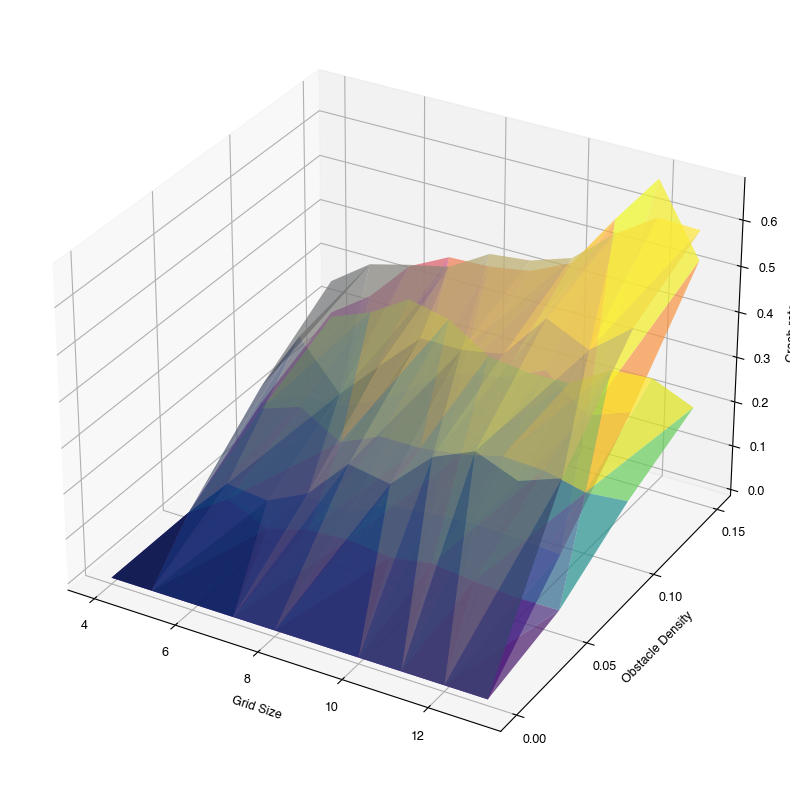

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

wind_param_vals = [0.9]

for wp in wind_param_vals:

    # Get the x, y, z values
    z_mc = crash_rates_mc.loc[:, :, wp]
    z_dp = crash_rates_dp.loc[:, :, wp]
    z_ip = crash_rates_ip.loc[:, :, wp]
    
    x = z_mc.index.get_level_values('grid_size')
    y = z_mc.index.get_level_values('obstacle_density')

    # Plot the 3D surfaces
    ax.plot_trisurf(x, y, z_mc, cmap='plasma', alpha = 0.7)
    ax.plot_trisurf(x, y, z_dp, cmap='viridis', alpha = 0.7)
    ax.plot_trisurf(x, y, z_ip, cmap='cividis', alpha = 0.7)


# Set labels for the axes
ax.set_xlabel('Grid Size')
ax.set_ylabel('Obstacle Density')
ax.set_zlabel('Crash rate')
ax.set_yticks(np.arange(0, 0.16, 0.05))

plt.show()

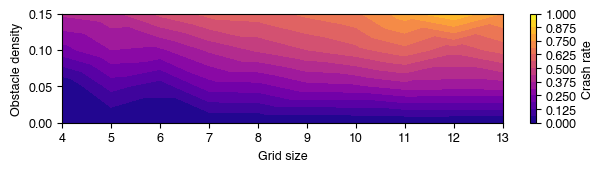

In [15]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri

fig = plt.figure(figsize=(fsp.text_width, 1.8))

wind_param_vals = [0.8]
method = 'mc'

for i, wp in enumerate(wind_param_vals):
    ax = fig.add_subplot(len(wind_param_vals), 1, i+1)
    
    # Get the x, y, z values
    z_mc = crash_rates_mc.loc[:, :, wp]
    z_dp = crash_rates_dp.loc[:, :, wp]
    z_ip = crash_rates_ip.loc[:, :, wp]
    
    x = z_mc.index.get_level_values('grid_size')
    y = z_mc.index.get_level_values('obstacle_density')

    # Create a triangulation of the irregular grid
    triang = tri.Triangulation(x, y)

    # Plot the contour
    if method == 'mc':
        levels = np.linspace(0, 1, 17)
        cs = ax.tricontourf(triang, z_mc, levels=levels, cmap='plasma')
    elif method == 'ip':
        levels = np.linspace(0, 1, 17)
        cs = ax.tricontourf(triang, z_ip, levels=levels, cmap='cividis')
    elif method == 'dp':
        levels = np.linspace(0, 0.5, 11)
        cs = ax.tricontourf(triang, z_dp, levels=levels, cmap='viridis')

    # Add a colorbar to show the scale of the values in the contours
    cbar = plt.colorbar(cs, ax=ax)

    # Set labels for the axes
    ax.set_xlabel('Grid size')
    ax.set_ylabel('Obstacle density')
    cbar.ax.set_ylabel('Crash rate')
    ax.set_yticks(np.arange(0, 0.16, 0.05))
    #ax.set_title(f'Wind Parameter = {wp}')
    plt.grid(False)


save = False
plt.tight_layout()
if save:
    plt.savefig(f'{fsp.fig_path}/4d-{method}-crash-rates-wind-{wind_param_vals[0]}.pdf')
plt.show()
